In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

# 한글 폰트 설정 - window, mac
#plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨짐 방지


In [99]:
# 데이터 불러오기

In [100]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
random_seed = 1106
set_random_seed(random_seed)

In [101]:
## sessions
sessions = pd.read_csv('sessions.csv')
train = pd.read_csv('train_users_2.csv')
train.rename(columns={'id':'user_id'},inplace=True)

In [102]:
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format = '%Y%m%d%H%M%S')
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'], errors='coerce')

# sessions 전처리 (df)

In [103]:
train_user_ids = set(train['user_id'])
# session 데이터에서 train 데이터에 존재하는 user_id만 필터링하여 사용
df = sessions[sessions['user_id'].isin(train_user_ids)]
df

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
5555275,nw9fwlyb5f,index,data,reservations,iPhone,245.0
5555276,nw9fwlyb5f,unavailabilities,data,unavailable_dates,iPhone,286.0
5555277,nw9fwlyb5f,notifications,submit,notifications,iPhone,830.0
5555278,nw9fwlyb5f,search,click,view_search_results,iPhone,101961.0


In [104]:
# 'NDF'인 경우에는 0으로, 그 외의 경우에는 1로 값을 갖는 바이너리 타겟 열 생성
train['binary_target'] = (train['country_destination'] != 'NDF').astype(int)
df = df.copy()
# df의 각 행에 대해 해당하는 유저 ID의 바이너리 타겟 값을 가져옵니다.
df.loc[:,'binary_target'] = df.loc[:,'user_id'].map(train.set_index('user_id')['binary_target'])
df['binary_target'].mean()

0.44786317409109533

In [105]:
df['action_flow'] = df['action'].astype('str') + '+' + df['action_type'].astype('str') + '+' + df['action_detail'].astype('str')

## 유저별 action order 생성
각 유저별 action_order 열에 로그 순서(1~) 입력

In [106]:
df['action_order'] = df.groupby('user_id').cumcount() + 1

## 유저 elapsed time 변경 
이전행부터 현재행까지 측정된 시간 -> 현재 액션의 총 걸린 시간으로 변경

In [107]:
# 한 칸씩 위로 당겨오기
df['secs_elapsed'] = df['secs_elapsed'].shift(-1)
# 유저별 마지막 elapsed time은 측정되지 않았으므로 nan
last_order = df.groupby('user_id').tail(1).index
df.loc[last_order, 'secs_elapsed'] = np.NaN

# 액션 EDA

만약 예약 유저만 사용한 action이 있다면 예약과 비예약 예측에 활용

## session에 유저의 인덱스가 섞여 있는지 확인
result: 각 유저별로 로그 index가 끊어지지 않도록 존재한다.

In [108]:
def count_user_chages(df):
    count=0
    prev_user_id = None

    for user_id in df['user_id']:
        if prev_user_id is None:
            prev_user_id = user_id
        elif user_id != prev_user_id:
            count+=1
            prev_user_id = user_id
    if prev_user_id is not None:
        count +=1
    return count

result = count_user_chages(df)
print(result)

73815


In [109]:
len(df['user_id'].unique())

73815

## 액션 타입별 flow 개수

In [110]:
max_length = max(len(str(i)) for i in df['action_type'].unique())

for i in df['action_type'].unique():
    print('action type:',str(i).ljust(max_length),' ','action combination count =',len(df[df['action_type']==i]['action_flow'].unique()))


action type: nan                action combination count = 0
action type: click              action combination count = 35
action type: data               action combination count = 19
action type: view               action combination count = 52
action type: submit             action combination count = 30
action type: message_post       action combination count = 10
action type: -unknown-          action combination count = 234
action type: booking_request    action combination count = 2
action type: partner_callback   action combination count = 1
action type: booking_response   action combination count = 1


In [111]:
## 액션별 예약 유저의 유니크한 수 확인 -> 예약 유저들이 사용한 action의 비중
## booking_df = df[df['binary_target']==1], action_columns: action, action_type, action_detail
def action_count_with_booking_users(booking_df,action_column):
    # 각 액션별로 고유한 사용자 수를 계산
    unique_users_per_flow = booking_df.groupby(action_column)['user_id'].nunique()
    
    # 총 사용자 수를 계산
    total_unique_users = booking_df['user_id'].nunique()
    
    # DataFrame 생성
    result_df = pd.DataFrame({
        'user_count': unique_users_per_flow,
        'ratio': unique_users_per_flow / total_unique_users
    })
    
    # 고유한 사용자 수에 따라 플로우를 내림차순으로 정렬
    sorted_result_df = result_df.sort_values(by='user_count', ascending=False)
    
    # 결과 출력
    print(sorted_result_df)

In [112]:
booking_df = df[df['binary_target']==1]
action_count_with_booking_users(booking_df,'action')
print('\n')
action_count_with_booking_users(booking_df,'action_type')
print('\n')
action_count_with_booking_users(booking_df,'action_detail')
print('\n')


                          user_count     ratio
action                                        
header_userpic                 24385  0.847466
show                           22801  0.792417
create                         20703  0.719504
index                          19603  0.681275
personalize                    18699  0.649858
...                              ...       ...
new_host                           1  0.000035
open_hard_fallback_modal           1  0.000035
booking                            1  0.000035
toggle_availability                1  0.000035
pricing                            1  0.000035

[302 rows x 2 columns]


                  user_count     ratio
action_type                           
submit                 27342  0.950233
data                   27246  0.946897
view                   26378  0.916730
click                  24703  0.858518
-unknown-              23277  0.808959
message_post           16048  0.557726
booking_request         8466  0.294224
partner_call

# train_with_sessions_data 그룹(sessions에 user_id를 갖는 train 데이터) 
세션 데이터가 있는 유저는 2014.01.01년부터 존재

1. 날짜 관련 데이터 -> 기간 변경('date_account_created', 'timestamp_first_active', 'date_first_booking')
2014년의 특수성을 제외하기 위해 첫 접속 및 가입으로부터 예약까지의 기간 등을 살펴보고자 함  
상관관계를 통해 기간에 따른 변화를 살펴보고 날짜에서 범주형 기간으로 변경
2. 성별(그대로 사용)과 나이(43.7%-NaN) 
3. 회원가입 - date_account_created(날짜), signup_method(사이트), signup_flow(페이지), signup_app(웹-어플) -> sign_up
4. 첫 접속과 관련된 정보 - timestamp_first_active(접속 날짜), first_affiliate_tracked(untracked 대부분), first_device_type(데스크탑-모바일) 범주화
5. 접속 경로 - affiliate_channel(채널),  affiliate_provider(채널 제공자) => channel_flow

6. 액션 - (action, type, detail), device_type(사용 장비), secs_elapsed(액션 경과 시간)

action에서 nan   -> unknown으로 변경
secs_elapsed nan -> 0으로 변경


## 피쳐 탐색 함수

In [113]:
def count_ratio(df,column):
    group_df = df.groupby(column)['binary_target']
    ratio = group_df.mean()
    count = group_df.count()
    count.sort_values(ascending=False,inplace=True)
    sorted_ratio = ratio[count.index]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    # 막대 그래프 (왼쪽 y축)
    count.plot(kind='bar', color='skyblue', alpha=0.7, label='count', ax=ax1)
    ax1.set_ylabel('count')
    #ax1.set_yscale('log')
    # 오른쪽 y축 추가
    ax2 = ax1.twinx()
    sorted_ratio.plot(kind='line', color='red', marker='o', label=' ratio', ax=ax2)
    ax2.set_ylabel('ratio')
    ax2.set_ylim(0,1.2)
    
    # 제목 및 범례 추가
    plt.title('count & booking ratio')
    
    # 그리드 추가
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 범례 위치 조정
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()

In [114]:
# sessions 데이터프레임에서 user_id만 추출하여 set으로 변환
sessions_user_ids = set(sessions['user_id'])

# train 데이터프레임에서 sessions에 있는 user_id만을 필터링
train_with_sessions_data = train[train['user_id'].isin(sessions_user_ids)]
train_with_sessions_data

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,binary_target
137021,d1mm9tcy42,2014-01-01,2014-01-01 00:09:36,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,1
137022,yo8nz8bqcq,2014-01-01,2014-01-01 00:15:58,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,0
137023,4grx6yxeby,2014-01-01,2014-01-01 00:16:39,NaT,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,0
137024,ncf87guaf0,2014-01-01,2014-01-01 00:21:46,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,0
137025,4rvqpxoh3h,2014-01-01,2014-01-01 00:26:19,2014-01-02,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaT,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,0
213447,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,0
213448,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaT,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,0
213449,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaT,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,0


## train_with_sessions_data 피쳐 생성

In [115]:
train_with_sessions_data = train_with_sessions_data.copy()
train_with_sessions_data['sign_up'] = train_with_sessions_data['signup_method'].astype('str') + '+' + train_with_sessions_data['signup_flow'].astype('str') + '+' + train_with_sessions_data['signup_app'].astype('str')
train_with_sessions_data['channel_flow'] = train_with_sessions_data['affiliate_channel'].astype('str') + '+' + train_with_sessions_data['affiliate_provider'].astype('str')

In [116]:
train_with_sessions_data['age'].isnull().sum()

32248

## 나이별 분포 
airbnb 정책: 18세 미만은 예약이 불가능 -> error  
방법: 18세 미만 -> 0으로 대체  
100세 이상 -> unknown으로 묶자 ex 100

In [117]:
train_with_sessions_data[(train_with_sessions_data['age']<19)].groupby('age')['binary_target'].agg(['count','mean'])

,count,mean
age,,
1.0,1,0.000000
2.0,1,0.000000
15.0,3,0.333333
16.0,13,0.076923
17.0,33,0.030303
18.0,190,0.489474


<Figure size 1500x800 with 0 Axes>

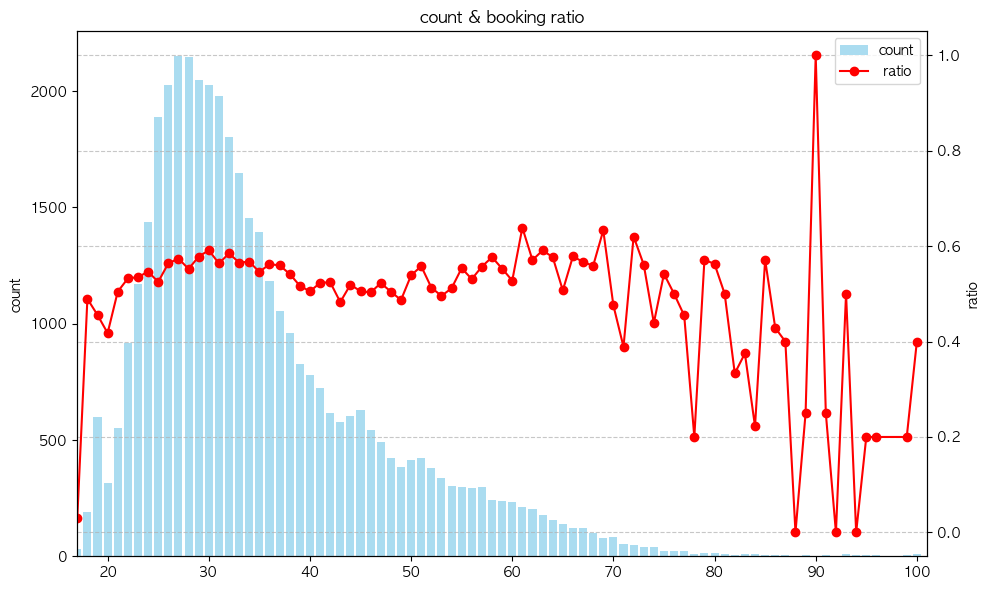

In [118]:
plt.figure(figsize=(15,8))

group_df = train_with_sessions_data[(train_with_sessions_data['age']<101)].groupby('age')['binary_target']
ratio = group_df.mean()
count = group_df.count()

fig, ax1 = plt.subplots(figsize=(10, 6))
# 막대 그래프 (왼쪽 y축)
ax1.bar(count.index,count, color='skyblue', alpha=0.7, label='count')
ax1.set_ylabel('count')
#ax1.set_yscale('log')

# 오른쪽 y축 추가
ax2 = ax1.twinx()
ax2.plot(ratio.index,ratio ,color='red', marker='o', label=' ratio')
ax2.set_ylabel('ratio')

# 제목 및 범례 추가
plt.title('count & booking ratio')
plt.xlim(17,101)

ax2.grid(axis='y', linestyle='--', alpha=0.7)
# 범례 위치 조정
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()

## 컬럼별 인원 수와 예약 비율

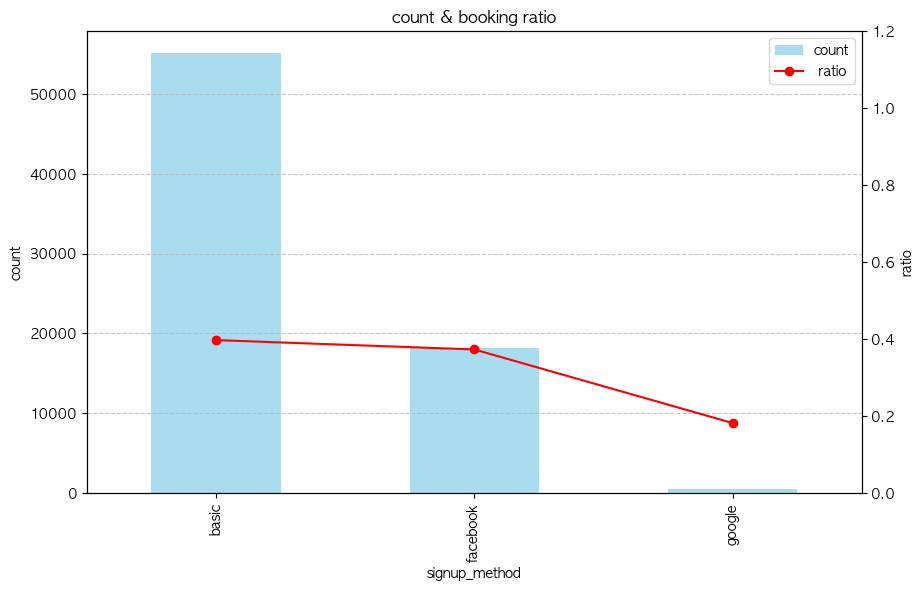

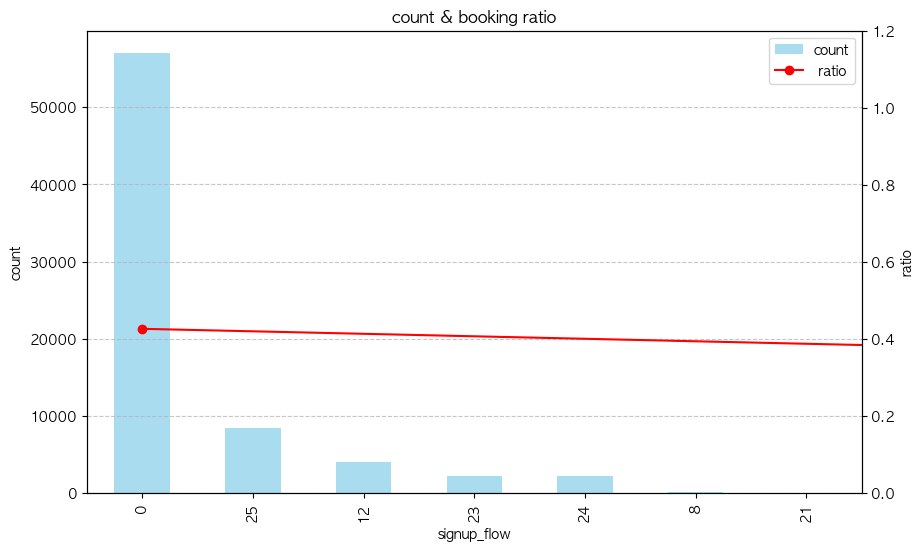

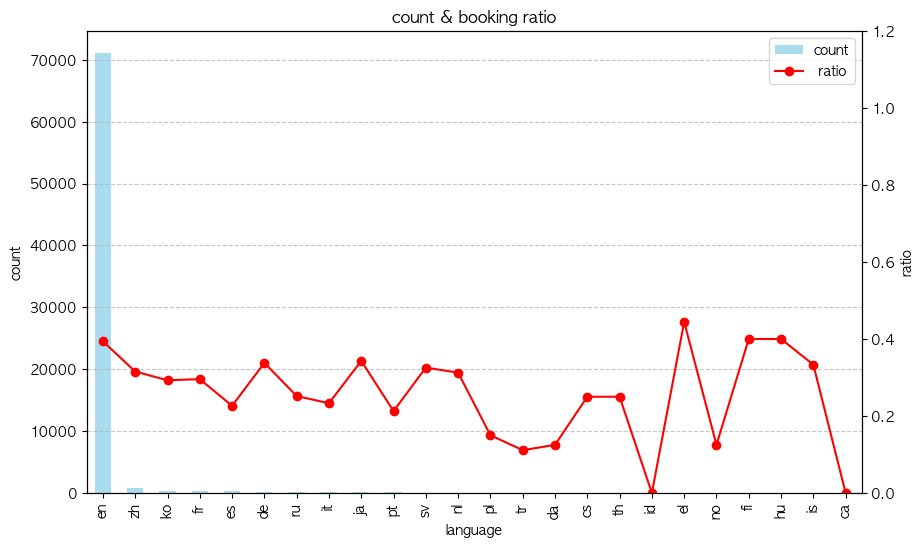

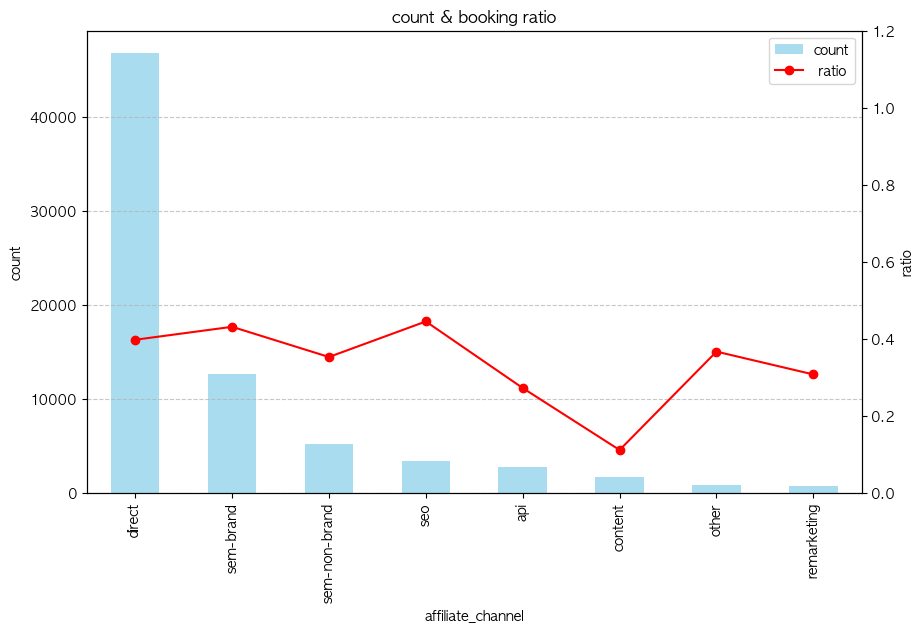

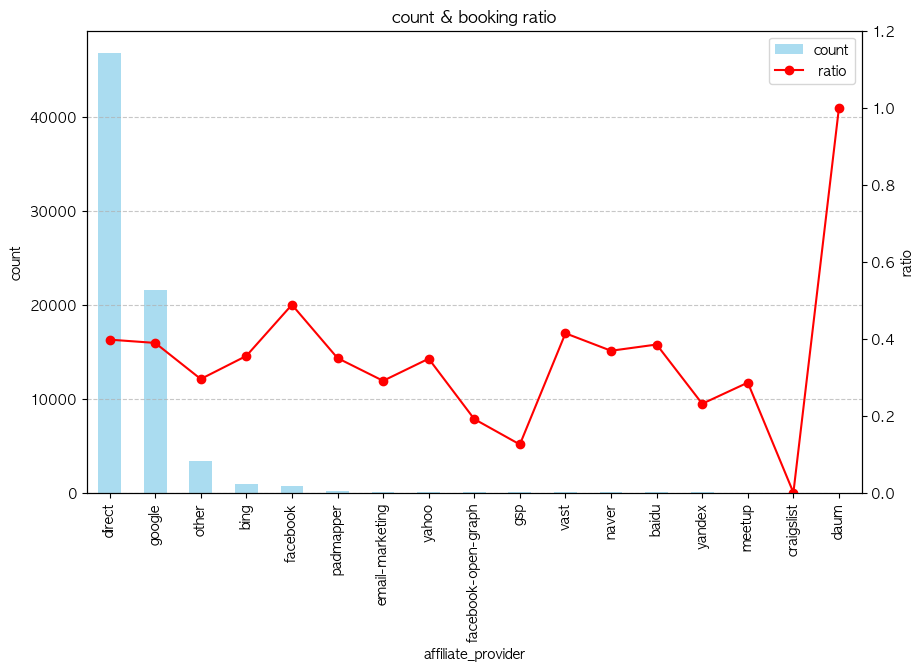

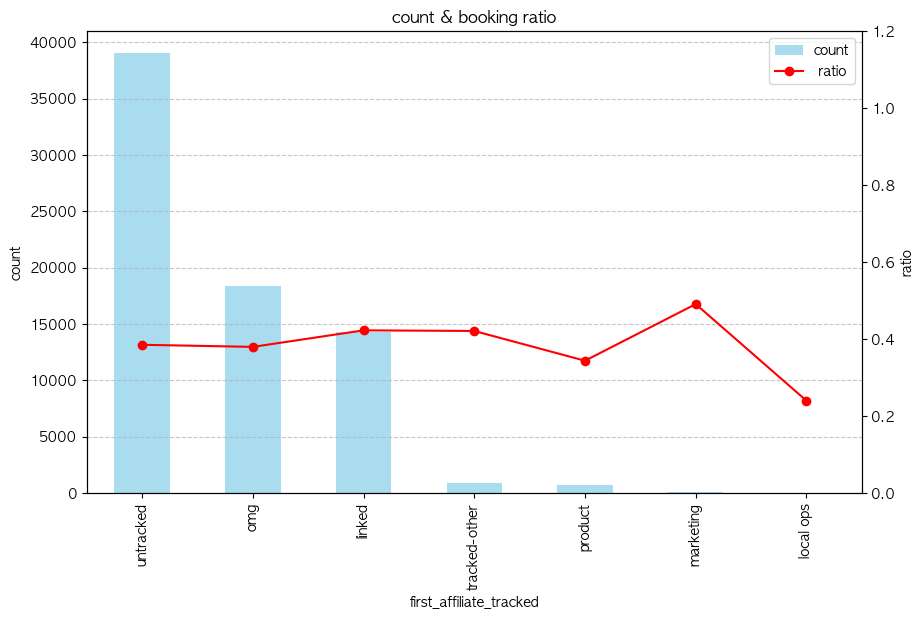

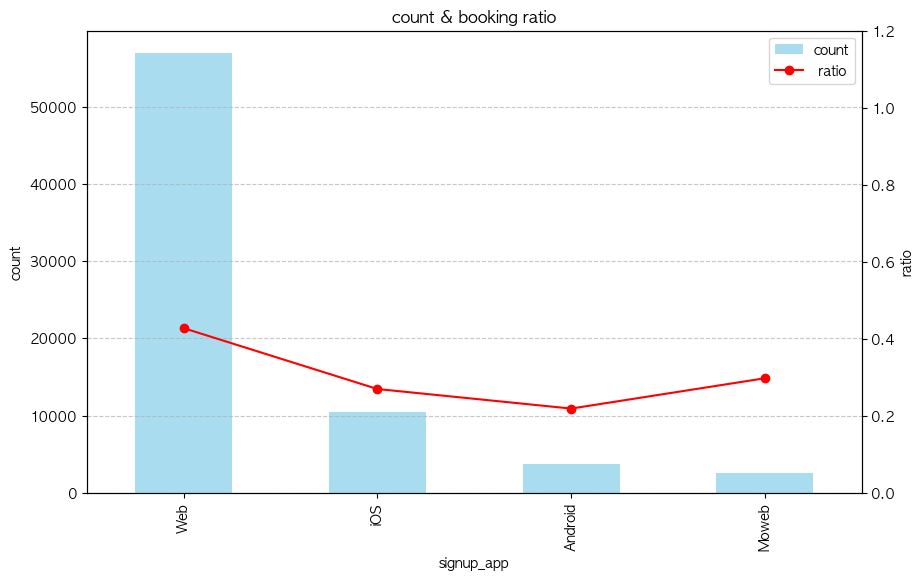

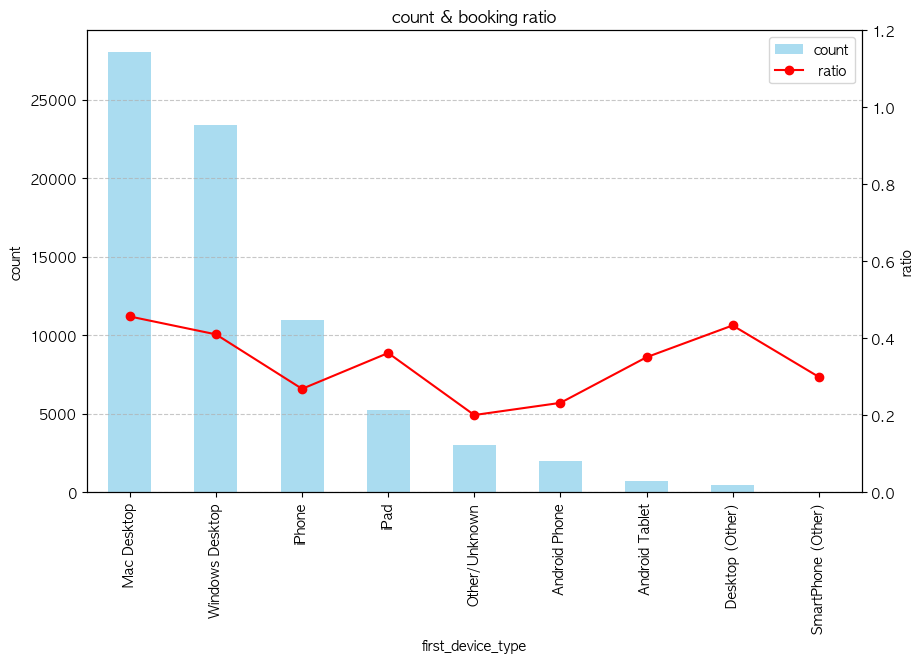

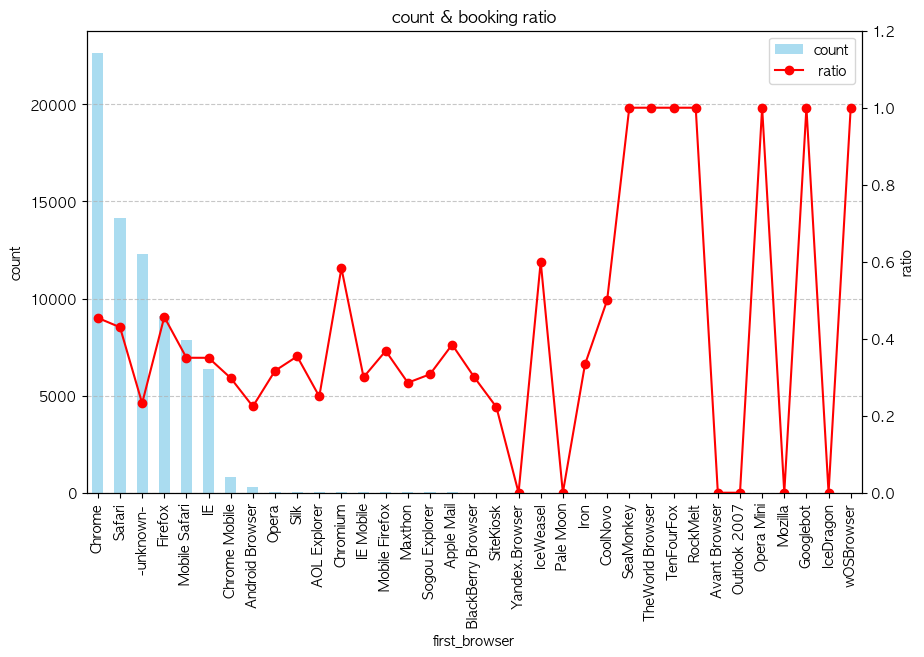

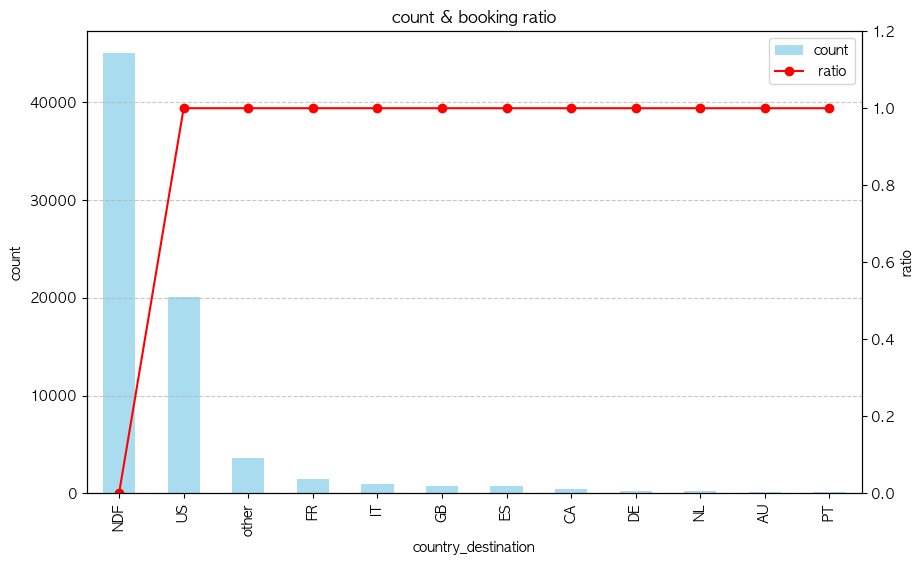

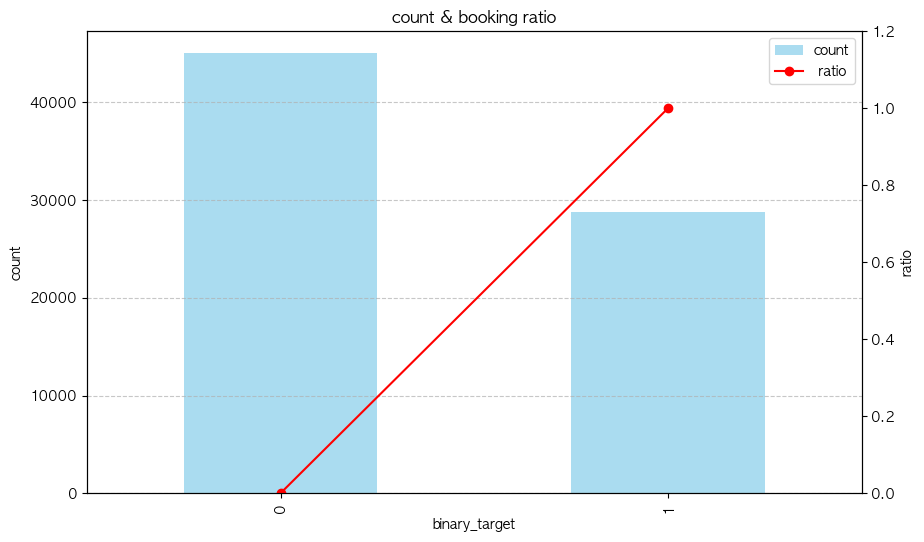

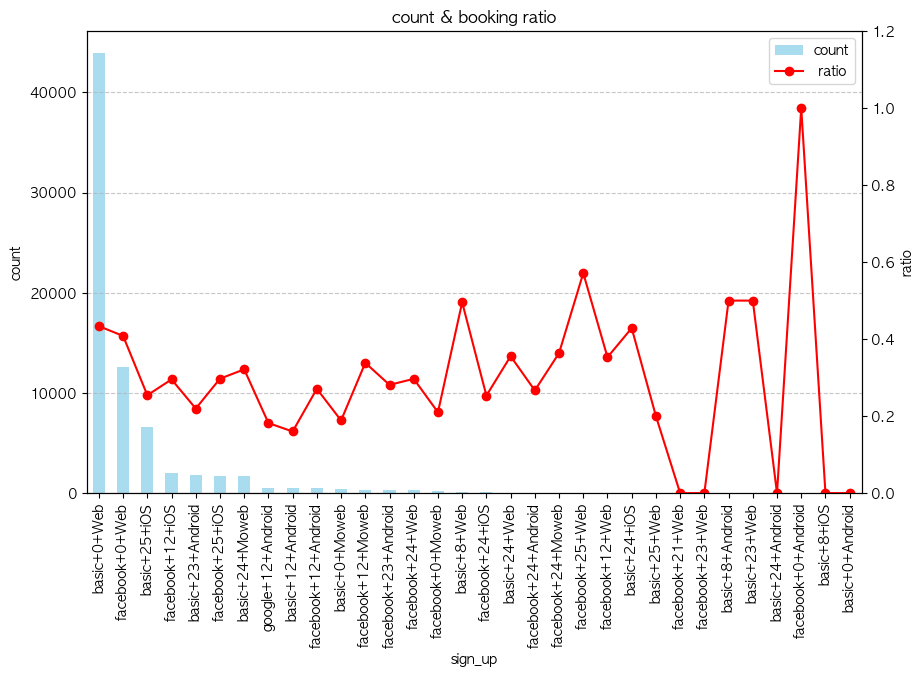

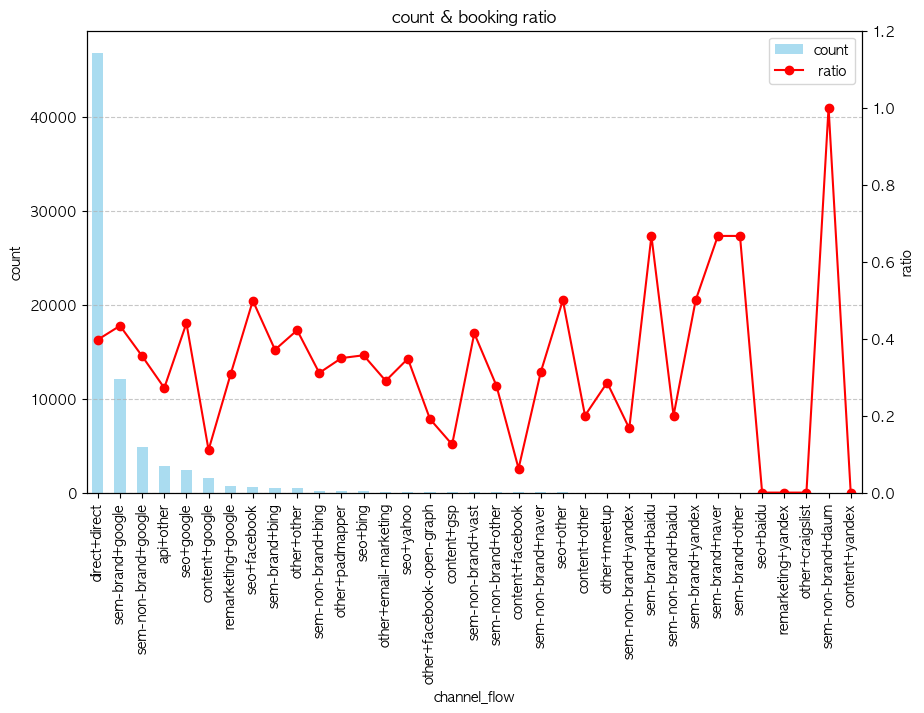

In [119]:
for i in train_with_sessions_data.columns[6:]:
    count_ratio(train_with_sessions_data,i)

# catboost 머신러닝

In [120]:
train_with_sessions_data.columns

Index(['user_id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'binary_target', 'sign_up',
       'channel_flow'],
      dtype='object')

In [121]:
# 데이터 준비
X = train_with_sessions_data.drop(['user_id','date_first_booking','country_destination','binary_target'], axis=1)  # 입력 특징
y = train_with_sessions_data['binary_target']  # 목표 변수

# 숫자가 아닌 타입의 열을 찾아서 cat_features에 추가
cat_features = [col for col in X.columns if X[col].dtype not in ['int64', 'float64']]
for col in cat_features:
    X[col] = X[col].astype(str)

# 훈련 데이터와 테스트 데이터로 나누기
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# CatBoost 모델 초기화
model = CatBoostClassifier(iterations=100,learning_rate=0.03, depth=6, loss_function='Logloss', eval_metric='Accuracy', random_seed=random_seed)

# 모델 학습
model.fit(X_train, y_train, cat_features=cat_features)
#y_pred = pd.Series(y_pred)

# 테스트 데이터 예측
y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred)
# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


0:	learn: 0.7196708	total: 16.6ms	remaining: 1.64s
1:	learn: 0.7196708	total: 33.5ms	remaining: 1.64s
2:	learn: 0.7196708	total: 47.2ms	remaining: 1.52s
3:	learn: 0.7197555	total: 59.9ms	remaining: 1.44s
4:	learn: 0.7197555	total: 71.7ms	remaining: 1.36s
5:	learn: 0.7196877	total: 82ms	remaining: 1.28s
6:	learn: 0.7197385	total: 94.9ms	remaining: 1.26s
7:	learn: 0.7197047	total: 107ms	remaining: 1.23s
8:	learn: 0.7196708	total: 117ms	remaining: 1.19s
9:	learn: 0.7196708	total: 129ms	remaining: 1.16s
10:	learn: 0.7196708	total: 141ms	remaining: 1.14s
11:	learn: 0.7196877	total: 151ms	remaining: 1.11s
12:	learn: 0.7197724	total: 161ms	remaining: 1.08s
13:	learn: 0.7197893	total: 173ms	remaining: 1.06s
14:	learn: 0.7197724	total: 183ms	remaining: 1.04s
15:	learn: 0.7197047	total: 194ms	remaining: 1.02s
16:	learn: 0.7197047	total: 206ms	remaining: 1s
17:	learn: 0.7197385	total: 218ms	remaining: 991ms
18:	learn: 0.7197385	total: 229ms	remaining: 976ms
19:	learn: 0.7197385	total: 244ms	remai

In [122]:
feature_importances = model.feature_importances_

# 피처 이름과 중요도를 함께 출력
for feature_name, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature_name}, Importance: {importance}")

Feature: date_account_created, Importance: 0.053793339082378946
Feature: timestamp_first_active, Importance: 0.0
Feature: gender, Importance: 2.731971530396709
Feature: age, Importance: 64.6009435122489
Feature: signup_method, Importance: 14.082946961463776
Feature: signup_flow, Importance: 0.22652968345857818
Feature: language, Importance: 0.6311763160957611
Feature: affiliate_channel, Importance: 2.4159131590868426
Feature: affiliate_provider, Importance: 0.25692873042441666
Feature: first_affiliate_tracked, Importance: 0.38135726074237175
Feature: signup_app, Importance: 1.8214407382838584
Feature: first_device_type, Importance: 1.8912962014261607
Feature: first_browser, Importance: 3.339762322535864
Feature: sign_up, Importance: 5.2199605450013244
Feature: channel_flow, Importance: 2.345979699753069
